<img src="pictures/logo_epfl.png" width=200/>

# Final Project - Basics of Mobile Robotics 

**Authors:** Valentin Suppa-Gallezot, Mehdi El Bouari, Thibault Golaz, Louis Marchand  


<img src="pictures/thymio_intro.jpg" width=400/>

### Table of Contents <a class="anchor" id="table"></a>

* [0. Introduction](#Introduction)
    * [0.0 Guidlines](#Guidlines)
    * [0.1. General overview of the code](#G_O)
    * [0.2. Setup of the map](#map)
    * [0.3. Essensial Library and inclusion](#library)

* [1. Vision](#vision)
    * [1.0 Most important function in Vision](#vis_function)
    * [1.1. Start and target Detection](#start_detect)
    * [1.2 Hough Transform](#hough)
    * [1.3 Template matching](#template)

* [2. Global Navigation](#global_nav)
    * [2.0. Main functions](#global_function)
    * [2.1. PyVisgraph library](#pyvisgraph)
    * [2.2 Implementation of the code](#global_code)
        * [2.2.1. The Dijkstra's algorithm](#djisktra)
        * [2.2.2. Visibility graph](#visibility)
        
* [3. Motion Control](#motion)
    * [3.0 Astolfi Controller](#astolfi)
    * [3.1 Auxiliary control functions ](#control_aux)
    * [3.2 Code implementation for motion functions](#3.3)
    

* [4. Local obstacle avoidance ](#local_avoidance)
    * [4.0. Potential fields method](#potential)

* [5. Filtering](#filtering)
    * [5.0. Kalman Filter](#5.0)
    * [5.1. Parameters](#5.1)
        * [5.1.0. Position and Velocity Covariance Matrix](#5.1.0)
    * [5.2. Speed Coefficient Measurement](#5.2)
    * [5.3. Kalman filter implementation](#5.3)
        * [5.3.0. Kalman filter matrices](#5.3.0)
        * [5.3.1. Kalman filter main function](#5.3.1)
        * [5.3.2. Test of Kalman filter](#5.3.2)

* [7. Conclusion](#conclusion)

## 0. Introduction <a class="anchor" id="Introduction"></a>

### 0.0. Guidlines <a class="anchor" id="Guidlines"></a>

For this project we had to construct and implement a mobile robot able to perform path finding method and movement based on vision-oriented programs. The robot we are using here is a Thymio-II robot.
  
The code will follow these guidelines:   
  
- **Create an environnment:** Our environnement is made of the thymio detectable thank to 2 green circles, obstacles (represented as black sheets of paper), a target represented by a red square of paper and 3D obstacles used to test local navigation (detected by the thymio sensors).  

- **Find the best path:** The objective is that the Thymio goes from its initial position on the map to the target.  
- **Motion control:** To control the motion of the robot we have implemented the astolfi controller presented during the lectures.

- **Kalman filter:** In the case where we do not receive the frames of the camera, we apply a Kalman filter knowing the last detected/predicted position and the speed given by the robot to compute the next position. We chose the Kalman filter because it seems very powerful and it is very well documented on internet.  

- **Local navigation:** While moving, the Thymio has to use local navigation to avoid physical obstacles that can be placed on its trajectory at any time.  


### 0.1. General overview of the code <a class="anchor" id="G_O"></a>

<img src="pictures/Diagram.png" width=700/>

On the previous diagram you can see the global architechture of the code that we have divided in five parts. They are the following: Vision, Global_Navigation, Filtering, Local_Navigation and motion control. These part will be discussed in details in the next chatpers.  

We have made a class corresponding to our thymio to have an easier acces to its state, attributes and methods. Moreover we decided to choose a finite state machine approach for the general structure of the code. During the main while (i.e the time the video flow is opened) the state of the robot (_self.state_) is evaluated to make it more responsive.  
The machine states are the following:  

- **State 0 :** In this step we are just after the opennig of the video's flow and the instanciation of the thymio, we have yet to visualize the obstacles, the target and the initial position of the thymio. We use some hough transforms and template matching to detect the obstacles, the circles representing the thymio, and the red square for the target. Once the data are transmited to the global_navigation functions, we can compute the visibility graph and compute the shortest path using a Djisktra algorithm (All these step are implemented in the PyVisgraph library). The path is represented by a list of points that need to be reached to go to the target. These points are at a certain distance from the obstacle and ensure a self travel is attained  

- **State 1 :** In this state we receive the Thymio's position. It is either detected by the camera or by the kalman filter applied to the last known position using the speed value returned by the thymio. We use the path computed during the state 0 to evaluate the next goal to be reached. If we exceed the length of the path, we go in the state 2 and the robot stops. In our code _i_ represent the next checkpoint we aim for. Once we have the starting point and the final point we can use an astolfi controller implemented in the Motion_Control part. If the sensors of the robot detect an obsatcle we use the potential field method to avoid it. This step of local avoidance is coded in the astolfi controller and enable the thymio to avoid the obstacle while still targeting the next goal.
 
- **State 2 :** This state represent the final step of the robot. In this step he robot stops and we shutdown the video flow and the computer window.    

The whole code is explained here in the form of a pseudo code:

### 0.2 Class RobotNav 

In order to have a better encapsulation by defining and showing only the most important parameters in the most explicit way as possible, we decided to create a class RobotNav where all the informations of the thymio are stored in it. You can find below the class' definition. 

In [1]:
class RobotNav:
    def __init__(self):
        """
        Initializing robot class to enable path_finding
        """
        # Robot geometry
        self.radius = 55
        self.length = 110
        self.width = 110
        self.dist_wheel = 95
        self.speed = 50

        # Coordinates of the two circles on the Thymio
        self.center_front = []
        self.center_back = []
        self.middle = []
        self.orientation = None

        # Values returned by the kalman filter
        self.x_kalman = None
        self.y_kalman = None
        self.theta_kalman = None
        self.path_kalman = []

        # Values we got from the picture
        self.x_img = None
        self.y_img = None
        self.theta_img = None
        self.path_img = []

        # Velocity in the x and y direction
        self.vx = None
        self.vy = None

        # Global navigation
        self.path = None
        self.start = None
        self.goal = None
        self.next_step = None

        # state ==> 0 not initialized/ 1=moving to target/ 2=finished
        self.state = 0
        self.crt_stp = 0

        self.shapes = None

### 0.3. Setup of the map <a class="anchor" id="map"></a>

For our map we use different elements:
- the obstacles in the form a black 2D polygons
- the target in the form of a red square 
- the thymio with is covered by two green circles
- Obstacles for local avoidance in the form of any 3d solids visible by the robot's sensors

<figure>
  <img src="pictures/map2.png" width="500" alt="map" />
  <figcaption> <center> <u>Figure 1:</u> Map of the setup for the robot<center> </figcaption></figure>

<figure>
  <img src="pictures/setup_camera.png" width="500" alt="map" />
  <figcaption> <center> <u>Figure 2:</u> Setup of the camera <center> </figcaption></figure>

### 0.4. Essensial Library and inclusion <a class="anchor" id="library"></a>

#### Premade libraries

In [16]:
import cv2 
import time
import math
import numpy as np
from matplotlib import pyplot as plt
from shapely.geometry import Polygon, Point, LineString
import pyvisgraph as vg
from geopandas import GeoSeries

#### Homemade functions

In [17]:
import Vision.vision as vs
import robot as rbt
import Global_Navigation.global_navigation as glb
import Motion_Control.thymio_control as ctrl

[Table of content](#table)

## 1. Vision  <a class="anchor" id="vision"></a>

### 1.0 Most important function in Vision  <a class="anchor" id="vis_function"></a>

| Function of Vision | Input | Output |
|:------|:------|:------|
|`detect_start1(image, begin = True)` |receive a frame when the program starts, begin allows to get only the coordinates and not the image|An image with a white rectangle on the two circles on the thymio and the start coordinates|
|`detect_target(image)`|receive a frame when the program starts|An image with a white rectangle on the target and the coordinates of the target|
|`detect_obstacle(image)`|receive an image with white rectangles on the start and the target|corner coordinates of each obstacle|

### 1.1. Start Detection with Hough Transform   <a class="anchor" id="start_detect"></a>

In order to obtain the starting point and the target point, we used two circles of different sizes. These two circles are placed on the robot. At the beginning of the program, a picture of the scene is taken. Using the library opencv and more precisely the function hough circles the center and the radius of the two circles are detected. Then by just computing the middle of these centers the center of the thymio (called starting point in the program is detected). Two circles are needed because in the following of the code it will allow to compute the orientation of the thymio. Theses 2 circles have a different radius that allows us to know the direction (fordward/backward) of the thymio.  

The Hough transform is a feature extraction technique used in image processing and computer vision. It is used to detect lines and other geometric shapes in images. The transform's name comes from its inventor, Paul Hough, who developed it in the 1950s.  

The Hough transform works by taking an image as input and transforming it into a new representation, known as Hough space, which encodes the geometric properties of the image. In this space, lines and other shapes are represented as points, which makes it easier to identify and extract them from the image.  

To use the Hough transform, the image is first converted into a binary image, where each pixel is either black or white. This is done by applying a threshold to the pixel intensities, so that pixels with intensities above the threshold are set to white and pixels below the threshold are set to black.  
 
Next, the Hough transform is applied to the binary image to create the Hough space. In this space, each point represents a possible line or shape in the image. The points are then grouped together into clusters, with each cluster representing a line or shape in the original image.  

Finally, the line or shape is extracted from the image by selecting the cluster with the most points and drawing a line or shape that passes through those points. This line or shape is then overlaid onto the original image to highlight the detected feature.  

The Hough transform is a powerful and widely used technique in image processing and computer vision. It is used in a variety of applications, such as identifying objects in images, detecting edges and lines in images, and extracting geometric features from images. 




<figure>
  <img src="pictures/hough.png" width="700" alt="map" />
  <figcaption> <center> <u>Figure 3:</u> Hough's transform <center> </figcaption></figure>

We inspired from here (https://www.instructables.com/Detecting-Circles-With-OpenCV-and-Python/) to developp the code for the Hough circles

In [18]:
def detect_start1(image, begin=True):
    img = image.copy()
    points = []
    rayon = []

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    gray = cv2.medianBlur(gray, 5)

    gray = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 11, 3.5)

    # Reduce noise
    kernel = np.ones((3, 3), np.uint8)
    gray = cv2.erode(gray, kernel, iterations=1)
    gray = cv2.dilate(gray, kernel, iterations=1)

    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, param1=25, param2=25, minRadius=10, maxRadius=50)

    #print(circles)
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")

        for (x, y, r) in circles:
            cv2.circle(img, (x, y), r, (0, 255, 0), 4)
            cv2.rectangle(img, (x - int(1.4 * r), y - int(1.4 * r)), (x + int(1.4 * r), y + int(1.4 * r)),
                          (255, 255, 255), -1)
            pos = (int(x), int(y))
            points.append(pos)
            rayon.append(r)

    test_detect = False  # will be useful for kalman filter, false if thymio position not detected
    center1 = 0
    center2 = 0
    start_coordinates = 0
    if len(points) == 2:
        test_detect = True
        start_coordinates = ((points[0][0] + points[1][0]) / 2, (points[0][1] + points[1][1]) / 2)
        if rayon[0] > rayon[1]:  # case bigger cercle backward 
            center2 = points[0]  
            center1 = points[1]  
        else:
            center1 = points[0]
            center2 = points[1]
    else:
        test_detect = False
    if test_detect == False:
        start_coordinates = (0,0)
        center1 = (0,0)
        center2 = (0,0)

    if begin:
        return img, start_coordinates, (center1, center2), test_detect
    else:
        return start_coordinates, (center1, center2), test_detect


### 1.2 Target detection with template matching:   <a class="anchor" id="hough"></a>

To implement the target (a red rectangle) detection we used a different method than for the start detection because we need to match a red rectangle. So we decided to use the match template function in the library cv2.  

Template matching is a technique used in image processing and computer vision to find instances of a template image in a larger image. It works by comparing the template image to multiple regions of the larger image, using a similarity measure such as normalized cross-correlation, to determine if the template is present in each region.  

To perform template matching, the template image is first converted into a binary image, where each pixel is either black or white. This is done by applying a threshold to the pixel intensities, so that pixels with intensities above the threshold are set to white and pixels below the threshold are set to black.  

Next, the template image is compared to multiple regions of the larger image using a similarity measure. The regions are typically smaller than the template image and are overlapped in order to ensure that all parts of the larger image are covered. The similarity measure is used to determine how closely the template image matches each region of the larger image.  

If a region of the larger image matches the template image above a certain threshold, it is considered to be a match. The location of the matching region is then recorded, and the process is repeated for the remaining regions of the larger image.  

Template matching is a useful technique for a variety of applications, such as object recognition, facial recognition, and pattern recognition. It is often used in conjunction with other image processing techniques, such as feature extraction and image segmentation, to improve the accuracy and efficiency of the matching process.  
 


<figure>
  <img src="pictures/template_match.jpg" width="700" alt="map" />
  <figcaption> <center> <u>Figure 5:</u> Template Matching using OpenCV <center> </figcaption></figure>

To apply this technique to our case wwe use the following template.

<figure>
  <img src="pictures/feuille_rouge.png" width="100" alt="map" />
  <figcaption> <center> <u>Figure 5:</u> Template for target detection with OpenCV <center> </figcaption></figure>

In [22]:
def detect_target(image):
    template = cv2.imread('Vision/feuille_rouge.png')
    _, w, h = template.shape[::-1]
    methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR', 'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF',
               'cv2.TM_SQDIFF_NORMED']

    img = image.copy()
    res = cv2.matchTemplate(img, template, cv2.TM_CCORR_NORMED)  
    _, _, min_loc, max_loc = cv2.minMaxLoc(res)  # take min if TM_SQDIFF or TM_SQDIFF_NORMED

    top_left = (max_loc[0], max_loc[1])
    bottom_right = (top_left[0] + w, top_left[1] + h)
    target_coordinates = (top_left[0] + w / 2, top_left[1] + h / 2)
    cv2.rectangle(img, top_left, bottom_right, (255, 255, 255),
                  -1)  # draw white rectangle

    return target_coordinates, img, res

### 1.3 Obstacle detetction

Since the starting point and the goal are detected it is time to compute the coordinates of the obstacle on the map. In our project the obstacles are black 2 dimensions shapes. They are positionned randomly on the field. In order to detect them the image is converted in black and white. To avoid some risk of confusion with the shapes on the thymio and the one for the target, white rectangles are drawn on them. Then, after applying the threshold, the obstacle are detected (#plot image). By using an opencv function, the coordinates of the contours are found. Finaylly by following the steps of this link https://stackoverflow.com/questions/50984205/how-to-find-corners-points-of-a-shape-in-an-image-in-opencv every corner coordinates of each shape are stored in a array. It will be helpful to compute the visibility graph.  

In [20]:
def detect_obstacle(image):
    """
    Detects the obstacles in the image using openCV functions
    :param image: image of the map with obstacles
    :return: gray, contours, shapes (all the corners of shapes), shape_center (centers of shapes)
    """
    img = image.copy()

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, gray = cv2.threshold(gray, 80, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    shapes = []
    shape_center = []
    for i in contours:
        size = cv2.contourArea(i)
        rect = cv2.minAreaRect(i)
        if size < 100000:
            gray = np.float32(gray)
            mask = np.zeros(gray.shape, dtype="uint8")
            cv2.fillPoly(mask, [i], (255, 255, 255))
            dst = cv2.cornerHarris(mask, 5, 3, 0.04)
            ret, dst = cv2.threshold(dst, 0.1 * dst.max(), 255, 0)
            dst = np.uint8(dst)
            ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
            corners = cv2.cornerSubPix(gray, np.float32(centroids), (5, 5), (-1, -1), criteria)
            if len(corners) > 3:
                shapes.append(corners[1:len(corners)])
                shape_center.append(np.mean(i, axis=0)[0])

    return gray, contours, shapes, shape_center

We use the Hough's transform to detect the obstacles and the circle representing the thymio. To do so, we use the functions written higher detect_obstacle() and def detect_start1().

<figure>
  <img src="pictures/map2.png" width="300" alt="map" />
  <figcaption> <center> <u>Figure 4:</u> Template Matching using OpenCV <center> </figcaption></figure>

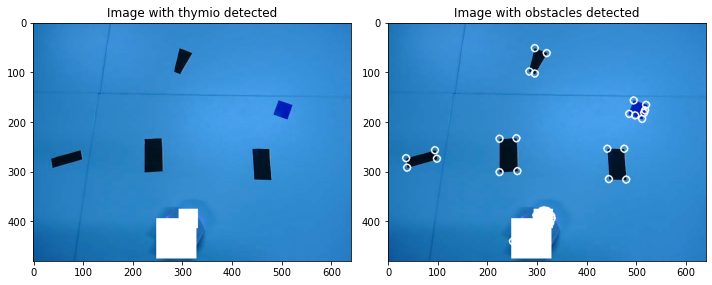

In [21]:
img = cv2.imread('pictures/map2.png')

img_thymio, start_coordinates, (center1, center2), test_detect = detect_start1(img, True)
img_obstacle = img_thymio.copy()
gray, contours, shapes, shape_center = detect_obstacle(img)

for i in range(len(shapes)):
    for j in range(len(shapes[i])):
        img_obstacle = cv2.circle(img_obstacle, (int(shapes[i][j][0]), int(shapes[i][j][1])), 7, (255,255,255), 2)

fig, ax = plt.subplots(1, 2,figsize=(10, 8))
ax[0].imshow(img_thymio)
ax[1].imshow(img_obstacle)  
ax[0].set_title("Image with thymio detected")
ax[1].set_title("Image with obstacles detected")
fig.tight_layout()
plt.show()

On the last images you can see that by using Hough's transform, we can detect obstacles and circles. It is important to notice that we need to apply some rectangles to mask the image before detecting obstacles. Here for the purpose of showing this, we did not apply rectangles on the target. As such, we can see that the target is detected as an obstacle whereas the circles aren't.

If we would have used the previously written function we can detect the target represented by the red square. This technique is useful as it can find colored target within a small step time. On the following cell we will show how we use template matching on the test image to detect the target.

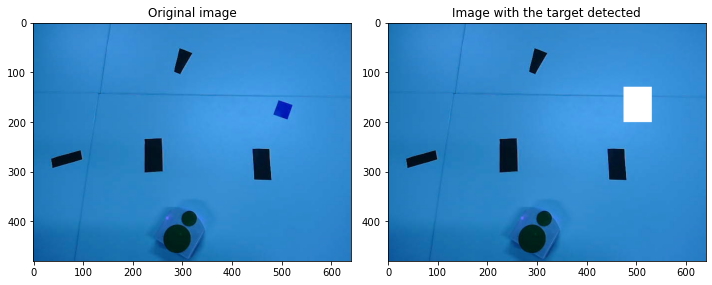

In [23]:
img = cv2.imread('pictures/map2.png')

target_coordinates, img_target, res = detect_target(img)

fig, ax = plt.subplots(1, 2,figsize=(10, 8))   
ax[0].imshow(img)
ax[1].imshow(img_target)
ax[0].set_title("Original image")
ax[1].set_title("Image with the target detected")
fig.tight_layout()
plt.show()

[Table of content](#table)

## 2. Global Navigation   <a class="anchor" id="global_nav"></a>

### 2.0. Main functions    <a class="anchor" id="global_function"></a>

This part of the code is the second step of our code, its goal is to compute the shortest path from the starting position of the thymio to the target while avoiding obstacles. All the elements used in this part are given by the vision part of the code they are transmitted as points.

| Function of Global Navigation | Input | Output |
|:------|:------|:------|
|`build_vis_graph(shapes, start, target)` |Takes a list of points representing the contours of the obstacles and two points standing for the starting and finishing goal of the path. The path is made using pyVisgraph library and avoid obstacle using a visibility graph and a djisktra algorithm |The shortest path in the form of a list of points and the shapes representing the obstacles (also represented as points|


<u>Links of interest:</u>  
    - PyVisgraph library: https://github.com/TaipanRex/pyvisgraph  
    - D.T. Lee : https://taipanrex.github.io/2016/10/19/Distance-Tables-Part-2-Lees-Visibility-Graph-Algorithm.html  

### 2.1. PyVisgraph library   <a class="anchor" id="pyvisgraph"></a>

Given a set of simple obstacle polygons, build a visibility graph and find the shortest path between two points.
Pyvisgraph is a MIT-licensed Python package for building visibility graphs from a list of simple obstacle polygons. The visibility graph algorithm (D.T. Lee) runs in O(N² log(N)) time. The shortest path is found using Djikstra's algorithm.

| Function of PyVisgraph Library | Input | Output |
|:------|:------|:------|
|`VisGraph()` |Nothing| Return the created instance of the visibility graph|
|`build()` |Method of the instance of visibility graph. Takes in a list of points representing the obstacles| Returns nothing but add all the points to the existing visibility graph|
|`shortest_path()` |Method of the VisGraph instance (here g).Takes in a target and a starting point under the form of Point(from the visGraph library)| Return the shortest path linking the starting point to the target under the form of a list of checkpoints.|

In the following cell you can find the pseudo code useful to create the shortest path:

### 2.2 Implementation of the code   <a class="anchor" id="global_code"></a>

We will know demonstrate how one can find the shortest path using the pyVisgraph library using the functions in the vision part. For this test we use the following image 

<figure>
  <img src="pictures/map2.png" width="400" alt="map" />
  <figcaption> <center> <u>Figure 6:</u> Picture of test obstacles<center> </figcaption></figure>

The link between the Vision and the global navigation is made by the function of vision `transmit_data()` which returns the starting and target points and the obstacles. These data will be used in the creation of the visibility graph after.

In [24]:
def transmit_data(image, show, margin):
    img_start, start_coor, (center1, center2), test_detect = detect_start1(image)
    target_coor, img_target, res_target = detect_target(img_start)
    gray2, contours, shapes, shape_center = detect_obstacle(img_target)
    for i in range(len(shapes)):
        shapes[i] = vs.sort_vertices_clockwise(shapes[i])
    shapes = add_margin(shapes, shape_center, margin)

    if show:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='row')
        ax1.imshow(image)
        ax2.imshow(img_target)
        ax3.imshow(gray2)

        plt.show()

    sz_img = np.shape(image)
    return start_coor, target_coor, shapes, sz_img, (center1, center2)

#### 2.2.1. The Dijkstra's algorithm:  <a class="anchor" id="djisktra"></a>

The Dijkstra's algorithm is a popular graph traversal algorithm that is used to find the shortest path between two nodes in a graph. It was developed by Dutch computer scientist Edsger Dijkstra in the 1950s and is widely used in computer science and other fields.  

The algorithm works by starting at the source node and exploring the neighboring nodes first, before moving on to the next-closest nodes. It uses a priority queue to keep track of the order in which the nodes are visited, and updates the distances between the nodes as it progresses. The algorithm terminates when the destination node is reached or when there are no more unexplored nodes.  

One way to visualize the algorithm is to think of it as a tree, where the source node is at the root and the destination node is a leaf. The algorithm moves from the root to the leaves, always choosing the shortest path to the next node.  


<figure>
  <img src="pictures/djisktra.png" width="400" alt="map" />
  <figcaption> <center> <u>Figure 7:</u> Djisktra graph<center> </figcaption></figure>

Here is an example of how the algorithm might work with A and J as the extremities of the graph:
- Start at the source node (A)
- Explore the neighboring nodes (B and C)
- Choose the closest neighboring node (B) and visit it
- Explore the neighboring nodes of B (D and E)
- Choose the closest neighboring node (E) and visit it
- Explore the neighboring nodes of D (F and D)
- Choose the closest neighboring node (F) and visit it
- Continue exploring the nodes until the destination node (K) is reached. Here J is the last node. Hence, we stop the algorithm.

In this example, the algorithm would visit the nodes in the following order: A -> B -> E -> F. This is the shortest path between the source and destination nodes.


#### 2.2.2. Visibility graph: <a class="anchor" id="visibility"></a>

A visibility graph is a type of graph that is used to represent the visibility between points in a plane. It is constructed by creating a vertex for each point in the plane, and then connecting two vertices with an edge if the corresponding points are visible to each other. This means that an edge exists between two vertices if there is a straight line between the points that does not intersect any other points in the plane.  

Visibility graphs are commonly used in computational geometry to solve a variety of problems, such as computing the shortest path between two points or finding the convex hull of a set of points. They are also used in other fields, such as robotics and computer graphics, where the visibility between points is important.  

One of the key benefits of visibility graphs is that they can be easily constructed from a set of points in the plane. This makes them a useful tool for solving problems that involve visibility, as they provide a simple and intuitive way to represent the relationships between the points. Additionally, visibility graphs can be used to solve problems that may be difficult or impossible to solve using other methods.  


<figure>
  <img src="pictures/visibility.png" width="400" alt="map" />
  <figcaption> <center> <u>Figure 8:</u> Djisktra graph<center> </figcaption></figure>

Now that we understand the theory behind Djisktra's algorithm and Visibility graphs, we can apply the first to the last one to compute the shortest path of our thymio in the map given by the vision functions. This is implemented by the following function `build_vis_graph()`.  

The `build_vis_graph()` function takes in the parameter described in the next cell and by using the functions from the pyVisgraph library described in section 2.2 process the shortest path with the Djisktra algorithm.  

In [25]:
def build_vis_graph(shapes, start, target):
    """
    Take the information extracted to compute the shortest path using visibility graphs algorithms
    :param shapes: List of all obstacles
    :param start: Starting position of the robot
    :param target: Goal identified
    :return: The shortest path to go to the goal from the initial position
    """
    start = vg.Point(str(start[0]), str(start[1]))
    target = vg.Point(str(target[0]), str(target[1]))
    vgPoints = []

    for i in range(len(shapes)):
        temp = []
        for j in range(len(shapes[i])):
            temp.append(vg.Point(shapes[i][j][0], shapes[i][j][1]))
        temp.append(vg.Point(shapes[i][0][0], shapes[i][0][1]))
        vgPoints.append(temp)

    g = vg.VisGraph()
    g.build(vgPoints)

    shortest_path = g.shortest_path(start, target)
    return shortest_path, shapes

With these two functions we can have the shortest path. But is is clear if we look at the figure 5 that our robot will hit the obstacle due to its width. Therefore we have to add a certain margin to our obstacles. This is implemented by the following function add_margin()

In [26]:
def add_margin(shapes, listCenters, margin):  
    for i in range(len(shapes)):
        for j in range(len(shapes[i])):
            u = shapes[i][j] - listCenters[i]
            u_norm = u / np.linalg.norm(u)
            shapes[i][j] = shapes[i][j] + margin*u_norm
    return shapes

In the following code we display the shortest path. We can see clearly the effect of the add_margin() function. The corners of the obstacles are displaced to avoid the problems raised before. One of the advantage of the visibility graph technique is its complexity. Indeed you can test after and see how fast the shortest path is computed.

100%|██████████| 2/2 [00:00<00:00, 501.23it/s]


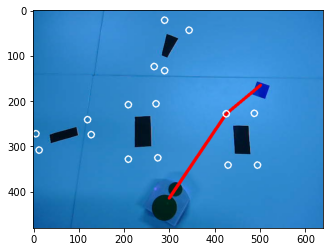

In [27]:
img = cv2.imread('pictures/map2.png')

start, target, shapes, size, start_points = transmit_data(img, False, 30)
shortest, shapes = build_vis_graph(shapes, start, target)

img = glb.draw_path(img, shortest)
for i in range(len(shapes)):
    for j in range(len(shapes[i])):
        cv2.circle(img, (int(shapes[i][j][0]), int(shapes[i][j][1])), 7, (255,255,255), 2)
plt.imshow(img)
plt.show()

[Table of content](#table)

## 3. Motion Control <a class="anchor" id="motion"></a>

### 3.0 Astolfi Controller <a class="anchor" id="astolfi"></a>

For the motion controller of the thymio, we opted for an Astolfi controller, which takes as input the coordinates of the thymio, its orientation, and the coordinates of the target location.
It then computes the following coordinates :
- $\rho$ : the distance from the thymio to the goal.
- $\alpha$ : the angle between the straight direction from the thymio to the goal, and the direction along thymio's orientation.
- $\beta$ : the orientation of the vector leading from the thymio to the goal.

These three coordinates can be seen in the image below:

<figure>
  <img src="pictures/Astolfi_schema.png" width="600" alt="map" />
  <figcaption> <center> <u>Figure 9:</u> Astolfi Schema <center> </figcaption></figure>

and they can be computed with the following formulas :

\begin{cases}  
\rho= \sqrt{\Delta x^2 + \Delta y^2} \\
\alpha = - \theta + atan2(\Delta y, \Delta x)  \\
\beta = - \theta - \alpha
\end{cases} 

where :
- $\Delta$x : the distance on the x axis from the thymio to the goal.
- $\Delta$y : the distance on the y axis from the thymio to the goal.
- $\theta$ : orientation of the thymio.

It can be shown that the control law : $v=k_\rho \times \rho$ and $\omega=k_\beta \times \beta + k_\alpha \times \alpha$ yields a closed loop system with a unique equilibrium point at $(\rho,\alpha,\beta)=(0,0,0)$, which are the coordinates we want to reach, and that this system is exponentially stable if: $k_\rho>0$, $k_\beta<0$, and $k_\alpha-k_\rho>0$. Lastly this set of equation had to be slighlty modified to take into account the flipped y-axis when working directly with pixels.

In our implementation of the Astolfi controller, we chose the coefficient $k_\beta$ to be as close to zero as possible, since this coefficient only affects the orientation of the thymio when it reaches its destination, which does not matter in the scope of our project. We also established a distance threshold so the thymio detects when it reaches its destination, and an angle threshold to avoid too much "zig-zagging". Lastly, since the speed is directly proportional to $\rho$, we had to establish and upper and lower limit to the speed in order to avoid speeds that are either too high or too low.

In [98]:
'''controller constants to tune accordingly'''
kp = 0.5  # >0
ka = 25  # > kp
kb = -0.01  # <0

'''speed limits and sensors thresholds to tune accordingly'''
v_max = 200
v_min = 20
thres_arrived = 50
angle_thres = 0.17
obstSpeedGain = np.array([6,4,-2,-6,-8])/100

'''Controller function'''
def astolfi(pos, theta, target, node, client):
    state = 0  
    delta_pos = [target[0] - pos[0], -(target[1] - pos[1])]
    rho = np.linalg.norm(delta_pos)
    alpha = -theta - np.arctan2(delta_pos[1], delta_pos[0])
    if alpha>np.pi:
        alpha-=2*np.pi
    elif alpha<-np.pi:
        alpha+=2*np.pi
    beta = theta - alpha
    if beta>np.pi:
        beta-=2*np.pi
    elif beta<-np.pi:
        beta+=2*np.pi
    sensors= np.array(get_prox_sensors(node, client)[0:5])
    vit_obst_left=np.sum(np.multiply(sensors,obstSpeedGain))
    vit_obst_right=np.sum(np.multiply(sensors,np.flip(obstSpeedGain)))
    if (alpha>angle_thres):
        omega = ka * alpha + kb * beta
    else: 
        omega=kb*beta
    
    omega = ka * alpha + kb * beta
    if rho > thres_arrived:
        v = kp * rho
        if v > v_max: v = v_max
        if v < v_min: v = v_min
    else:
        v = 0
        state = 1
    left_speed = v - omega + vit_obst_left
    right_speed = v + omega + vit_obst_right
    set_motor_speed(int(right_speed), int(left_speed), node)
    return state

This function sets up the motors according to the Astolfi controler, and returns a 1 if the target is reached and 0 otherwise, making it possible to simply recursively call this function all the while updating the thymio's position and orientation every time, until the the function returns a 1, meaning that the goal was reached, at wich point the target is updated to the next interest point, enabling the robot to visit all the nodes in the track

### 3.1. Thymio control with aseba <a class="anchor" id="3.1"></a>

### 3.2. Auxiliary control functions <a class="anchor" id="control_aux"></a>

We also created some auxiliary motion control functions to help control the thymio, which will be quickly described in the following section:

| Function for motion control | Input | Output |
|:------|:------|:------|
|thym_motors(right, left)|the speed of the right motor 'right' and the speed of the left motor 'left'|Creates the speed structure to control the Thymio's motors|
|set_motor_speed(sr, sl, node)|the speed of the right motor 'sr', the speed of the left motor 'sl', and the node of the thymio|Sets the speed of the thymio|
|stop_motors(node)|the node of the thymio|Stops motor motion|

###  3.3. Code implementation for motion functions <a class="anchor" id="3.3"></a>

[Table of content](#table)

## 4. Local obstacle avoidance <a class="anchor" id="local_avoidance"></a>

The local obstacle avoidance was directly implemented in the thymios's controller by means of potential fields.

###  4.0. Potential fields method <a class="anchor" id="potential"></a>

One potential method for avoiding obstacles in mobile robotics is called potential field avoidance. This method involves creating a virtual potential field around the robot, with the robot moving towards the goal while avoiding obstacles by following the gradient of the potential field.  

The potential field is typically generated by assigning a repulsive force to obstacles in the environment, and an attractive force to the goal. The repulsive force increases as the robot gets closer to an obstacle, and the attractive force increases as the robot gets closer to the goal. By following the gradient of the potential field, the robot is able to navigate around obstacles and move towards the goal.  

There are several variations of this approach, including dynamic potential fields, where the potential field is updated in real-time based on the robot's current position and the location of obstacles. Another variation is called gradient descent, where the robot moves directly towards the goal by following the negative gradient of the potential field.  

Overall, potential field avoidance is a popular and effective method for obstacle avoidance in mobile robotics, and can be customized to suit the specific needs of the robot and its environment.  

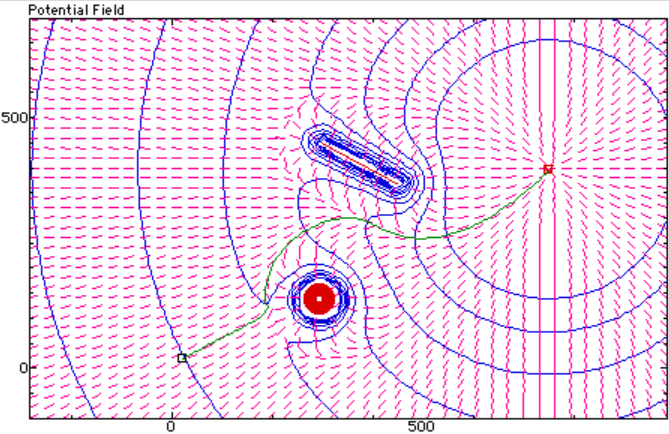


In the `astolfi` function displayed in the previous section, the proximity sensors are surveyed, and the values of the sensors are then multiplied by speed gains and added up, then injected directly into the motors speed, enabling the thymio to avoid the obstacle while still remaining on its normal control law.

The advantages of this method, compared to regular obstacle avoidance method where we switch states whenever an obstacle is detected, is that the robot remains on the same control law, making it very easy for the thymio to regain his normal course once the obstacle is avoided.

However, the drawbacks with such methods is the existence of local minimas where the robot gets stuck, for exeample if we put an obstacle direcly between the robot and the goal. As we are well aware of this limitation, our tests wil stay clear of this situation.  

You can observe in the next cell the part of the code that enable the obstacle avoidance in local navigation.

<figure>
  <img src="pictures/local_minima.png" width="600" alt="map" />
  <figcaption> <center> <u>Figure 9:</u> Local extremum (minima) <center> </figcaption></figure>

[Table of content](#table)

## 5. Filtering <a class="anchor" id="filtering"></a>

### 5.0 Kalman Filter  <a class="anchor" id="5.0"></a>

Kalman filtering is a technique used to estimate the state of a system from noisy and uncertain measurements. In the example of predicting position from speed measurements, Kalman filtering could be used to estimate the position of an object based on noisy and uncertain speed measurements.  

To do this, the Kalman filter would use the known relation between position and speed to predict the position of the object at the next time step based on the current position and the measured speed. It would then use the new position measurement to refine this prediction and produce the final estimate of the object's position.  

For example, suppose an object is moving at a constant speed of 10 meters per second. The position of the object is initially unknown, but its speed is measured to be 9.9 meters per second. The Kalman filter would use this speed measurement to predict that the object's position will change by 9.9 meters in the next second. Then, when the actual position of the object is measured, the Kalman filter would use this measurement to refine its prediction and produce a more accurate estimate of the object's position. This process would be repeated at each time step to produce a sequence of estimates of the object's position.  

Overall, Kalman filtering is a powerful and widely used technique for estimating the state of systems from noisy and uncertain measurements. In the example of predicting position from speed measurements, it can be used to produce accurate estimates of an object's position even in the presence of measurement noise.  


<figure>
  <img src="pictures/kalman.jpg" width="600" alt="map" />
  <figcaption> <center> <u>Figure 9:</u> Kalman exemple in 1 dimension <center> </figcaption></figure>

### 5.1 Parameters <a class="anchor" id="5.1"></a>

To estimate the position of our robot we defined its state as: 
\begin{align*} x^{t} = \begin{pmatrix} x_t \\ y_t \\ v_x \\ v_y \end{pmatrix} \end{align*}

We can then write our model to estimate the next state: 
\begin{align*} x^{t+1} = A*x^t + B*u^t + w^t*y^t \end{align*}

Here we have: 
\begin{align*} A = \begin{pmatrix} 1 & 0 & T_s & 0 \\ 0 & 1 & 0 & T_s \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{pmatrix} \quad and \quad B = \begin{pmatrix} T_s & 0 \\ 0 & T_s \\ 1 & 0 \\ 0 & 1 \end{pmatrix}  \end{align*}

$T_s$ represents the time between each samples are taken, it will allow us to always get the position from the input $u^t$ and the previous sate $x^t$. $x^t$ was defined before and the input is:
\begin{align*} u^t = \begin{pmatrix} dv_x \\ dv_y \end{pmatrix} \end{align*}

$dv_x$ and $dv_y$ represents the difference between the new speed given to the robot compared to the old speed. Then we can write: \begin{align*} dv_x = v^t_x - v^{t-1}_x \quad and \quad dv_y = v^t_y - v^{t-1}_y \end{align*}
With: \begin{align*} v^t_x = \frac{v_{right} + v_{left}}{2}*cos(\theta) \\ v^t_y = -\frac{v_{right} + v_{left}}{2}*sin(\theta) \end{align*}

Here $v_{right}$ and $v_{left}$ are the speed given to the Thymio's right and left motors and $\theta$ is the orientation of the robot compared to the x-axis.

#### 5.1.0 Position and Velocity Covariance Matrix <a class="anchor" id="5.1.1"></a>

This covariance matrix will be used exclusively when the robot is detected by the camera, this means when the filter will need to correct the position estimation got by the camera. If the the detection is not true then this matrix will be set to infinite in order to get the inverse matrix equal to zero which leads to a zero gain too.

To calculate this covariance matrix we first concidered the position measurement. We started by taking multiple measurments on the robot when it's not moving and then we calculated the covariance of all the values got that way. 

We can see that in our case we get nearly all the points in a range of 2 pixels, which can be due to the lighting conditions or to an inaccuracy on the templates made to detect the circles.  

As the result is quiet the same for x and y-axis we will take the same value for both, as we want to take the worst case scenario we'll take 0.48 for both variances. We then have, for the moment: \begin{align*} R = \begin{pmatrix} 0.48 & 0 & 0 & 0 \\ 0 & 0.48 & 0 & 0 \\ 0 & 0 & R_{33} & 0 \\ 0 & 0 & 0 & R_{44} \end{pmatrix} \end{align*}



[[0.47787879 0.12474747]
 [0.12474747 0.47222222]]


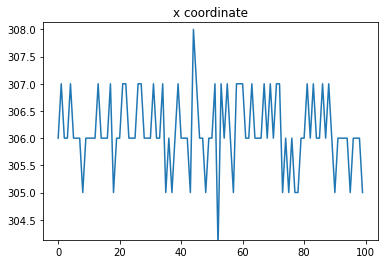

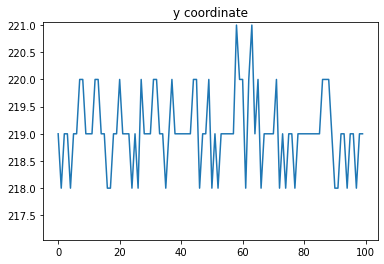

In [5]:
NMBR_ITER = 100
i = 0
thymio_x = np.array([])
thymio_y = np.array([])
cap = cv2.VideoCapture(1)
img = vs.get_image(cap)
for i in range(NMBR_ITER):
    ret, frame = cap.read()
    pos_thy, two_centres, test_detect = vs.detect_start1(frame, False)
    if test_detect:
        thymio_x = np.append(thymio_x, pos_thy[0])
        thymio_y = np.append(thymio_y, pos_thy[1])

mean_x = np.mean(thymio_x)
mean_y = np.mean(thymio_y)

plt.figure()
plt.plot(thymio_x)
plt.title("x coordinate")
    
plt.figure()
plt.plot(thymio_y)
plt.title("y coordinate")
R_pos = np.cov(thymio_x, thymio_y)
print(R_pos)

The same reasoning is applied to measure the velocity covariance.
Here we got different values for x and y-axis, this is probably due to our setup and again to the lighting condition. So this time we will take different values for $v_x$ and $v_y$ to have the best accuracy possible. 

So finally we can set our covariance matrix as:

\begin{align*} R = \begin{pmatrix} 0.48 & 0 & 0 & 0 \\ 0 & 0.48 & 0 & 0 \\ 0 & 0 & 0.64 & 0 \\ 0 & 0 & 0 & 0.49 \end{pmatrix} \end{align*}



#### Speed Coefficient Measurement  <a class="anchor" id="5.2"></a>

First of all we need to compute the speed coefficient which will allow us to get the velocity in px/s from the raw value passed to the robot. Here we get COEFF_SPEED = 0.48

In [6]:
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 36b6a277-86a1-4fde-a73f-2ed95257a43d

In [17]:
cap = cv2.VideoCapture(1)
img = vs.get_image(cap)
thymio = rbt.RobotNav()

ret, frame = cap.read()
pos_thy0, two_centres, test_detect = vs.detect_start1(frame, False)

time_start = time.time()
ctrl.set_motor_speed(90, 90, node)
time.sleep(5)
ctrl.stop_motors(node)
time_stop = time.time()

cap.release()
cv2.destroyAllWindows()

cap = cv2.VideoCapture(1)
img = vs.get_image(cap)
ret, frame = cap.read()
pos_thy1, two_centres, test_detect = vs.detect_start1(frame, False)

cap.release()
cv2.destroyAllWindows()
    
delta_pos0 = pos_thy1[0] - pos_thy0[0]
delta_pos1 = pos_thy1[1] - pos_thy0[1]
delta_t = time_stop - time_start

speed = math.sqrt(delta_pos0**2 + delta_pos1**2) / delta_t
COEFF_SPEED = speed/50 
print(COEFF_SPEED)

0.4890189137785207


Now that we have this coefficient we can compute the velocity variance by making the thymio move along x-axis for the variance of $v_x$ and along y-axis for the variance of $v_y$. 

As before we'll then get with the camera the position of Thymio and compute his orientation. We'll iterate measurements NMBR_ITER times in order to have a good approximation of the variance.

In [9]:
def compute_angle(front, back):
    x = front[0] - back[0]
    y = front[1] - back[1]
    angle = math.atan2(-y, x)
    return angle

In [10]:
NMBR_ITER = 100
MEAN_SPEED = 90

Thymio_vx = []

cap = cv2.VideoCapture(1)
img = vs.get_image(cap)
ctrl.set_motor_speed(MEAN_SPEED,MEAN_SPEED,node)

for i in range(NMBR_ITER):
    ret, frame = cap.read()
    pos_thy, two_centers, test_detect = vs.detect_start1(frame, False)
    if test_detect:
        alpha = compute_angle(two_centers[0], two_centers[1])
        vx = COEFF_SPEED*(ctrl.get_motors_speed(node, client)[0] + ctrl.get_motors_speed(node, client)[1])/2*math.cos(alpha)
        Thymio_vx.append(vx)

ctrl.stop_motors(node)
cap.release()

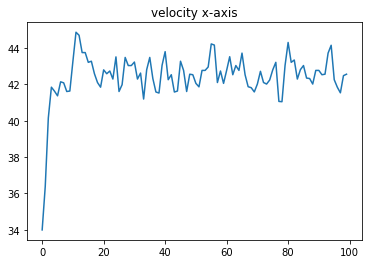

In [11]:
plt.figure()
plt.title("velocity x-axis")
plt.plot(Thymio_vx)

We can see that the first ~5 values are not relevant for the measurement, we'll just delete them to avoid any mistake in the variance.

0.6337509773403047


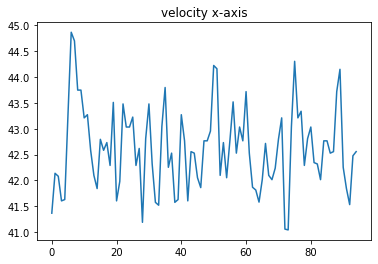

In [12]:
Thymio_vx = np.delete(Thymio_vx, np.arange(5), 0)
plt.plot(Thymio_vx)
plt.title("velocity x-axis")
variance_vx = np.var(Thymio_vx)
print(variance_vx)

0.49412540445223246


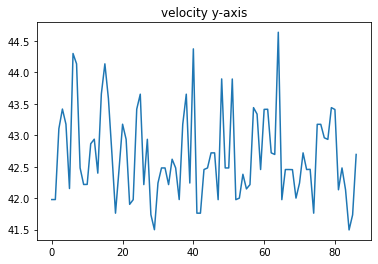

In [16]:
Thymio_vy = []

cap = cv2.VideoCapture(1)
img = vs.get_image(cap)
ctrl.set_motor_speed(MEAN_SPEED,MEAN_SPEED,node)

for i in range(NMBR_ITER):
    ret, frame = cap.read()
    pos_thy, two_centers, test_detect = vs.detect_start1(frame, False)
    if test_detect:
        alpha = compute_angle(two_centers[0], two_centers[1])
        vy = -COEFF_SPEED*(ctrl.get_motors_speed(node, client)[0] + ctrl.get_motors_speed(node, client)[1])/2*math.sin(alpha)
        Thymio_vy.append(vy)

ctrl.stop_motors(node)
cap.release()
Thymio_vy = np.delete(Thymio_vy, np.arange(5), 0) #Same reasoning as for vx
plt.figure()
plt.plot(Thymio_vy)
plt.title("velocity y-axis")
variance_vy = np.var(Thymio_vy)
print(variance_vy)

#### 5.1.1 Process Noise Covariance

At first we started with a Process Noise Covariance matrix that we set arbitrarily, and we wanted to tune it by trying with our Kalman Filter which values was giving us the best results. 

Unfortunately our Kalman Filter didn't work properly on our project and then we weren't able to use the results to tune the elements of our matrix. 

Thus, we have: 

\begin{align*} Q = \begin{pmatrix} 2 & 0 & 0 & 0 \\ 0 & 2 & 0 & 0 \\ 0 & 0 & 2 & 0 \\ 0 & 0 & 0 & 2 \end{pmatrix} \end{align*}

### 5.2. Kalman filter implementation <a class="anchor" id="5.3"></a>

For the implementation of the kalman filter, we create a list x_est, representing the estimated state of the system along the simulation time. X_est[i] is in the form [x, y, vx, vy]. P_est is a list of variance matrices, it begins as kxI matrix where I is the identidy matrix and k an integer arbitrary choosen. This variance matrix is updated at each step to follow optimally  the state of the robot. In our code we use the kalman_filter() function made from the course.  

We could also have used a library such as pyfilter, but we thought it was important to understand such a crucial filter. Tou can see below the code of the function.

| Function for Kalman filtering | Input | Output |
|:------|:------|:------|
|kalman_filter(x, y, vx, vy, x_est_prev, p_est_prev, dvx=0, dvy=0, detection=True)|The last position mesured (x,y), the last speed mesured(vx, vy), the speed and position estimated before, the variance matrix updated at each call of the function, the speed delta (dvx, dvy) and the detection boolean that specify if the filter is use to predict or correct the position|Returns a structure composed of the predicted speed and position and the variance matrix updated|

#### 5.3.0. Kalman filter matrices <a class="anchor" id="5.3.0"></a>

In [100]:
T_s = 0.1
A = np.array([[1.0, 0, T_s, 0],[0, 1.0, 0, T_s],[0, 0, 1.0, 0],[0, 0, 0, 1.0]])
B = np.array([[T_s, 0], [0, T_s], [1.0, 0], [0, 1.0]])
Q = np.diag([2, 2, 2, 2])
H = np.eye(4)

#### 5.3.1. Kalman filter main function <a class="anchor" id="5.3.1"></a>

In [101]:
def kalman_filter(x, y, vx, vy, x_est_prev, p_est_prev, dvx=0, dvy=0, detection=True):
    
    Input = np.array([dvx, dvy])
    x_est_a_priori = np.dot(A, x_est_prev) + np.dot(B, Input)
    
    p_est_a_priori = np.dot(A, np.dot(p_est_prev, A.T))
    p_est_a_priori = p_est_a_priori + Q if type(Q) != type(None) else p_est_a_priori
    
    if detection:
        R = np.diag([0.48, 0.48, 0.64, 0.49])
    else:
        R = np.diag([math.inf, math.inf, math.inf, math.inf])
        
    y = np.array([x, y, vx, vy])
    i = y - np.dot(H, x_est_a_priori)
    S = np.dot(H, np.dot(p_est_a_priori, H.T)) + R
    K = np.dot(p_est_a_priori, np.dot(H.T, np.linalg.inv(S)))
    
    x_est = x_est_a_priori + np.dot(K, i)
    p_est = p_est_a_priori - np.dot(K, np.dot(H, p_est_a_priori))
    
    return x_est, p_est

Whithin the following cell, you can see how a prediction is made using kalaman filter from an initial position and speed measurement. We create here a set of fake data to show the effect of a kalman filter.

#### 5.3.2 Test of Kalman filter <a class="anchor" id="5.3.2"></a>

In [102]:
def create_fake_data_sinus(size, speed):
    position = []
    vitesse = []
    for i in range(size):
        position.append([10*math.sin(i), 10*math.sin(i)])
        vitesse.append([10*math.cos(i), 10*math.cos(i)])
    return position, vitesse

In [103]:
size, speed = 50, 10
position, vitesse = create_fake_data_sinus(size, speed)
x_est = [[position[0][0], position[0][1], vitesse[0][0], vitesse[0][1]]] # real position
P_est = [1000 * np.eye(4)] # guess of P_est
for i in range(size):
    new_x_est, new_P_est = kalman_filter(x_est[i][0], x_est[i][1], x_est[i][2], x_est[i][3], x_est[i] ,
                                             P_est[i], vitesse[i][0] - x_est[i][2] , vitesse[i][1] - x_est[i][3], detection= False)
    x_est.append(new_x_est)
    P_est.append(new_P_est)

<function matplotlib.pyplot.show(close=None, block=None)>

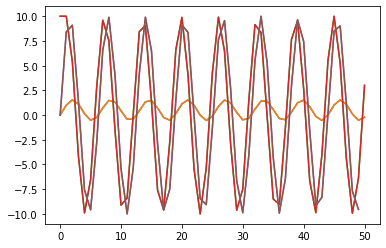

In [104]:
plt.plot(x_est)
plt.plot(position)
plt.show

We can observe that the kalman filter follow quite well the real data. Nevertheless, the initial condition maybe redefined to have a better prediction.


[Table of content](#table)

## 7. Conclusion <a class="anchor" id="conclusion"></a>

This project was very interesting despite we had only few weeks, few hardware resources (nothing to hang the camera above the map for instance) and not much time meeting and learning how to work with our groupmate. As such, we focused on making a robust and working code to execute the given task (find the target). We needed to ensure the knowledge of the robot position at every time even without the acces to the camera. Also we used a simple astolfi controller with tunable parameters to make the robot move.   

On the previous section you could see our final code implemented. We see that the robot is following the path line with small error. This error could be even lowered by using the kalman filter to correct it. This filter wasn't easy to implement but gives us satisfactory results.  

It could be interestion to apply a Model Predictive Control method on the robot to implement the local avoidance procedure in the main controller. By using this powerful method we could just recompute controller with the new obstacles and the old ones.

[Table of content](#table)